In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [20]:
df = pd.read_csv('../../data/train_V2.csv')
# target 1 row null data drop
test_df = pd.read_csv('../../data/test_V2.csv')
df = df.dropna()

In [21]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## 데이터 수집 및 정제

- **Data** : Kaggle에서 제공하는 아래의 파일을 사용 예정
> - train_V2.csv
> - test_V2.csv  
      
- **Data fileds**
>  - **Id** - 플레이어 아이디
>  - **groupId** - 매치 내에서 그룹을 식별하기 위한 ID입니다.   
        같은 그룹의 플레이어가 다른 경기에서 플레이하는 경우 매번 다른 groupId를 갖습니다.
>  - **matchId** - 일치를 식별하는 ID입니다.   
        훈련 세트와 테스트 세트 모두에 일치하는 항목이 없습니다.
>  - **assists** - 이 플레이어가 피해를 주었고 팀원들에 의해 사망한 적 플레이어의 수입니다. 팀원과 같이 싸웠다는 지표
>  - **boosts** - 사용된 부스트 아이템의 수입니다.
>  - **DamageDealt** - 가한 총 피해량입니다. 
        참고: 자신이 입힌 피해는 차감됩니다. 팀 합산
>  - **DBNO** - 다운이된 상 플레이어의 수입니다.
        - Down But No Out'의 약자입니다. 듀오나 스쿼드 플레이 중 체력(HP)을 모두 잃으면 이 모드로 진입합니다.   
        - 이 모드에서 듀오 또는 분대원은 당신을 치유할 수 있으며 이것이 우리가 이것을 아웃으로 간주하지 않는 이유입니다.   
        - 'Revive State'는 BATTLEGROUNDS의 기능으로 쓰러진 분대원을 소생시키는 데 사용할 수 있습니다.   
        - HP가 0이 되면 DBNO 상태가 됩니다.  
        - 아이템을 크롤링 및 드롭할 수만 있으며 이 상태에서는 아이템을 쏘거나 사용할 수 없습니다.
>  - **headshotKills** - 헤드샷으로 사망한 적 플레이어의 수입니다.
>  - **heals** - 사용된 치유 아이템의 수입니다.
        - PUBG에는 붕대, 응급 처치 키트 및 의료 키트의 세 가지 기본 heals 옵션이 있습니다.
>  - **killPlace** - 죽인 적 플레이어 수의 경기 순위입니다.  
>  - **killPoints** - 플레이어의 킬 기반 외부 순위입니다.  
        (이것을 킬만 중요한 Elo 순위라고 생각하십시오.)  
        rankPoints에 -1 이외의 값이 있는 경우 killPoints의 0은 "없음"으로 처리되어야 합니다.
>  - **kills** - 죽인 적 플레이어의 수.
>  - **killStreaks** - 짧은 시간에 죽인 적 플레이어의 최대 수입니다.
>  - **longKill** - 사망 시 사망한 플레이어와 플레이어 사이의 최장 거리입니다.  
        플레이어를 쓰러뜨리고 drive away하면 가장 긴 킬 통계가 나올 수 있으므로 이는 오해의 소지가 있습니다.
>  - **matchDuration** - 경기 시간(초)입니다.
>  - **matchType** - 데이터의 출처인 게임 모드를 식별하는 문자열입니다.   
        표준 모드는 "solo", "duo", "squad", "solo-fpp", "duo-fpp" 및 "squad-fpp"입니다.  
        다른 모드는 이벤트 또는 사용자 지정 일치에서 가져온 것입니다.
>  - **maxPlace** - 경기에서 데이터가 있는 최악의 위치입니다.  
        데이터가 배치를 건너뛰는 경우가 있으므로 numGroups와 일치하지 않을 수 있습니다.
>  - **numGroups** - 경기에서 데이터가 있는 그룹의 수입니다.
>  - **rankPoints** - 플레이어의 Elo와 같은 순위입니다.  
        이 순위는 일관성이 없으며 API의 다음 버전에서 더 이상 사용되지 않으므로 주의해서 사용하십시오.  
        -1 값은 "없음"을 대신합니다.
>  - **revives** - 이 플레이어가 팀원을 소생시킨 횟수입니다.
>  - **rideDistance** - 미터로 측정한 차량의 총 이동 거리입니다.
>  - **roadKills** - 차량에 있는 동안 킬 수입니다.
>  - **swimDistance** - 미터로 측정한 수영으로 이동한 총 거리.
>  - **teamKills** - 이 플레이어가 팀원을 죽인 횟수입니다.
>  - **vehicleDestroys** - 파괴된 차량의 수입니다.
>  - **walkDistance** - 미터로 측정한 도보로 이동한 총 거리.
>  - **weaponsAcquired** - 획득한 무기의 수입니다.
>  - **winPoints** - 승리 기반 플레이어의 외부 순위입니다.  
        (이것을 승리만이 중요한 Elo 순위라고 생각하십시오.)  
        rankPoints에 -1 이외의 값이 있는 경우 winPoints의 0은 "없음"으로 처리되어야 합니다.
>  - **winPlacePerc** - 예측 대상입니다.  
        이것은 백분위수 승리 배치로, 1은 1위, 0은 경기의 마지막 순위에 해당합니다.  
        numGroups가 아닌 maxPlace에서 계산되므로 일치 항목에서 청크가 누락될 수 있습니다.


# EDA
- <font size=4>1. 6가지 모드(ffp,ttp 각 3가지 모드)별 컬럼별 시각화하여 차이 비교</font> 
- <font size=4>2. groupid 5이상 분포 확인 및 이상치 여부 처리</font>
<font size=4></font>

In [27]:
df['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [28]:
df= df[~(df['matchType'] =='flaretpp')&
   ~(df['matchType'] =='flarefpp')&
   ~(df['matchType'] =='crashfpp')&
   ~(df['matchType'] =='crashtpp')&
   ~(df['matchType'] =='normal-squad-fpp')&
   ~(df['matchType'] =='normal-solo-fpp')&
   ~(df['matchType'] =='normal-duo-fpp')&
   ~(df['matchType'] =='normal-duo')&
   ~(df['matchType'] =='normal-squad')&
   ~(df['matchType'] =='normal-solo')]

In [29]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [30]:
df['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo'],
      dtype=object)

## 1.6가지 모드(ffp,ttp 각 3가지 모드)별 컬럼별 시각화하여 차이 비교

In [114]:
df_1 = df[df['matchType'].str.contains('solo')]
df_2 = df[df['matchType'].str.contains('duo')]
df_3 = df[df['matchType'].str.contains('squad')]

In [115]:
solo_1 = df_1[~df_1['matchType'].str.contains('fpp')].groupby(['winPlacePerc']).mean()
solo_2 = df_1[df_1['matchType'].str.contains('fpp')].groupby(['winPlacePerc']).mean()

duo_1 = df_2[~df_2['matchType'].str.contains('fpp')].groupby(['winPlacePerc']).mean()
duo_2 = df_2[df_2['matchType'].str.contains('fpp')].groupby(['winPlacePerc']).mean()

squad_1 = df_3[~df_3['matchType'].str.contains('fpp')].groupby(['winPlacePerc']).mean()
squad_2 = df_3[df_3['matchType'].str.contains('fpp')].groupby(['winPlacePerc']).mean()

In [130]:
# killplace 제외한 컬럼들 
cols = ['assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals','killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints']

======================================== ASSISTS ============================================================



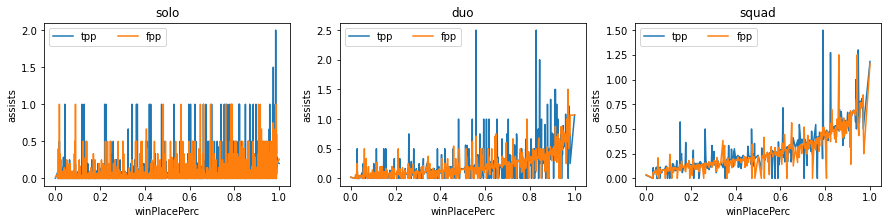

======================================== BOOSTS ============================================================



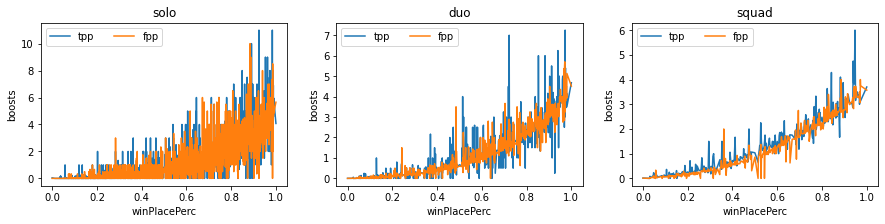

======================================== DAMAGEDEALT ============================================================



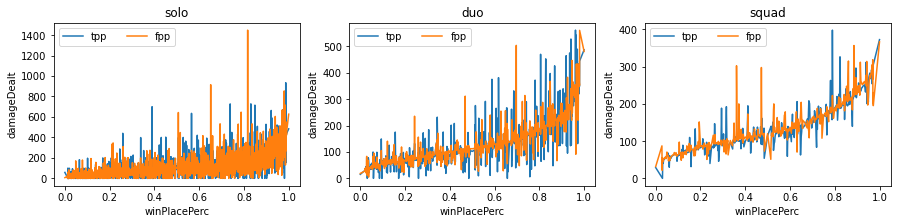

======================================== DBNOS ============================================================



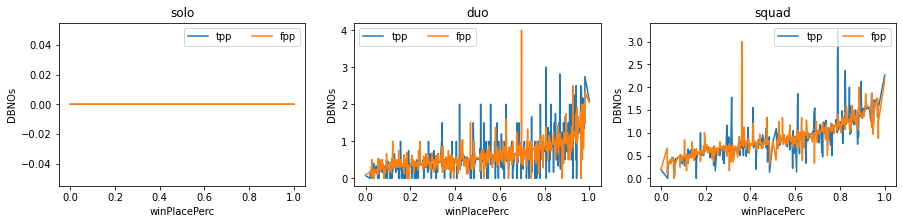

======================================== HEADSHOTKILLS ============================================================



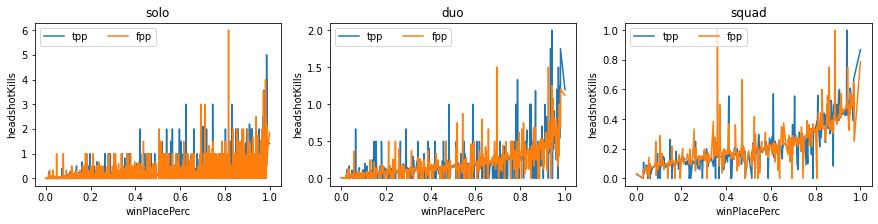

======================================== HEALS ============================================================



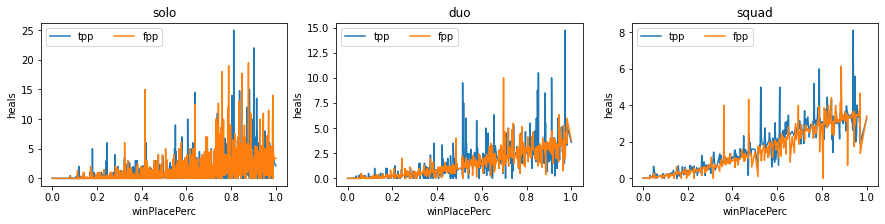

======================================== KILLPOINTS ============================================================



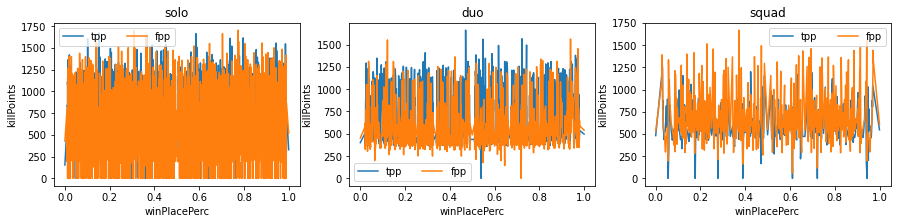

======================================== KILLS ============================================================



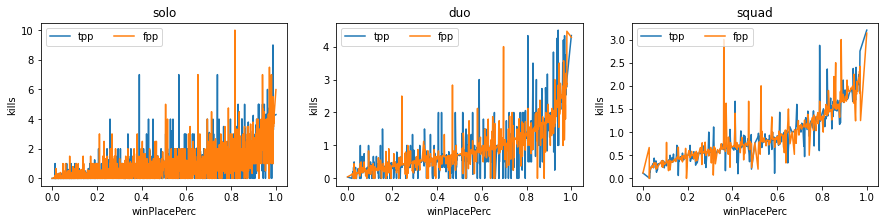

======================================== KILLSTREAKS ============================================================



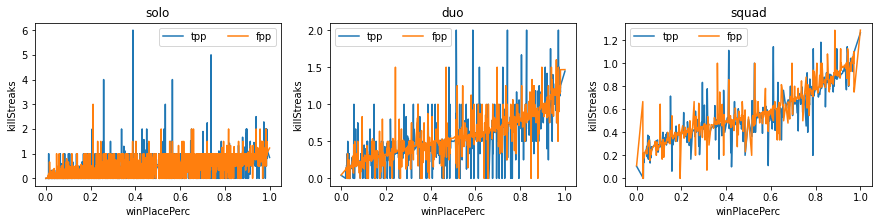

======================================== LONGESTKILL ============================================================



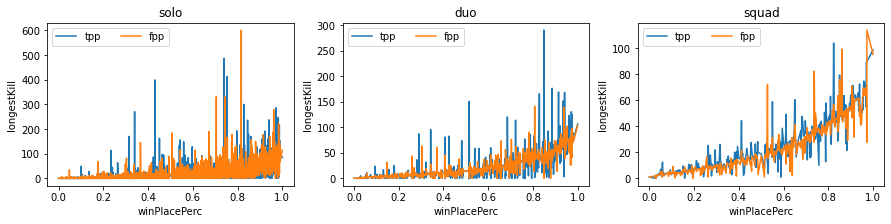

======================================== MATCHDURATION ============================================================



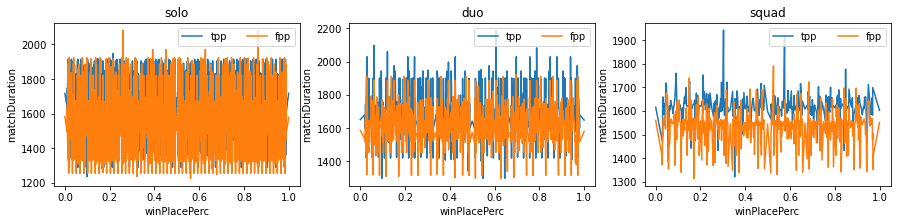

======================================== MAXPLACE ============================================================



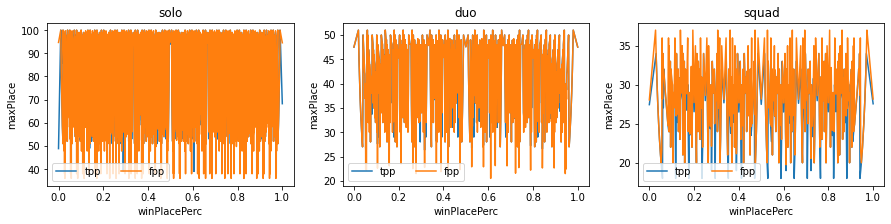

======================================== NUMGROUPS ============================================================



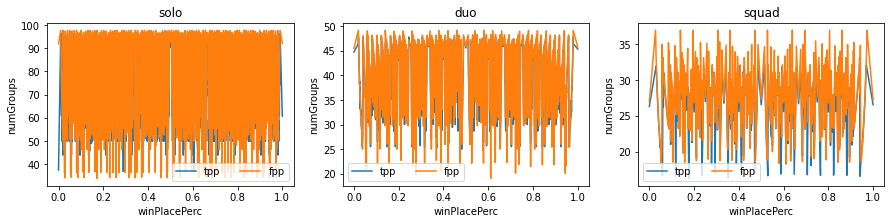

======================================== RANKPOINTS ============================================================



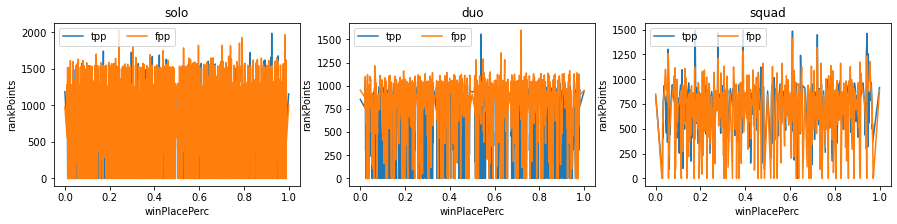

======================================== REVIVES ============================================================



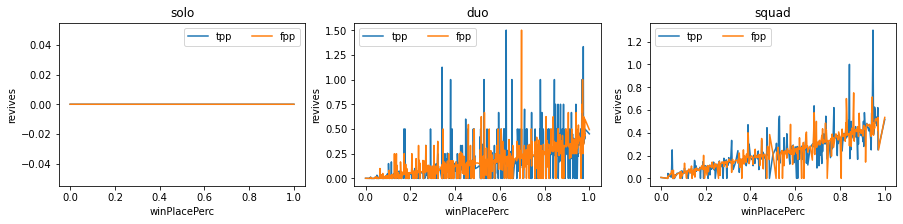

======================================== RIDEDISTANCE ============================================================



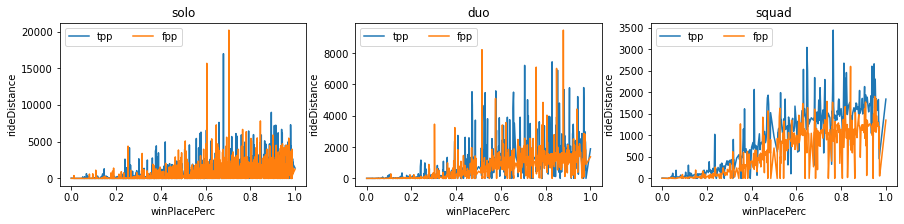

======================================== ROADKILLS ============================================================



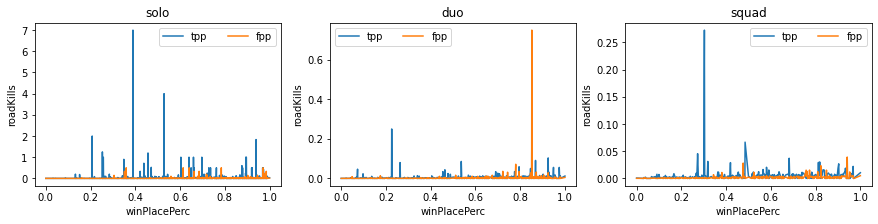

======================================== SWIMDISTANCE ============================================================



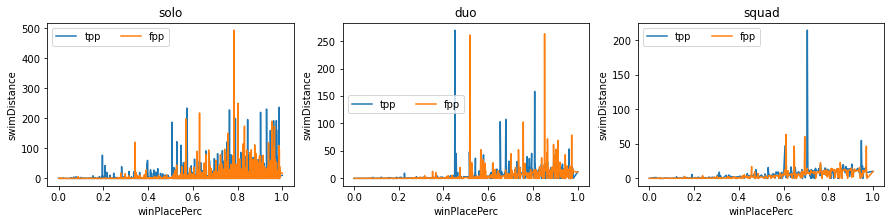

======================================== TEAMKILLS ============================================================



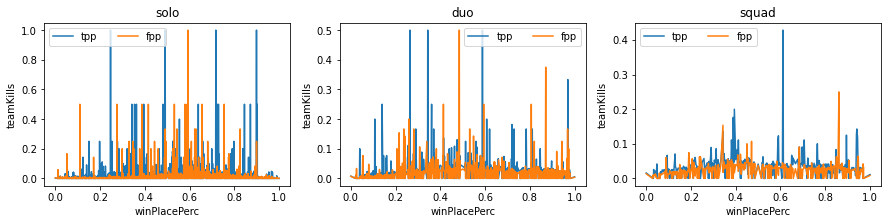

======================================== VEHICLEDESTROYS ============================================================



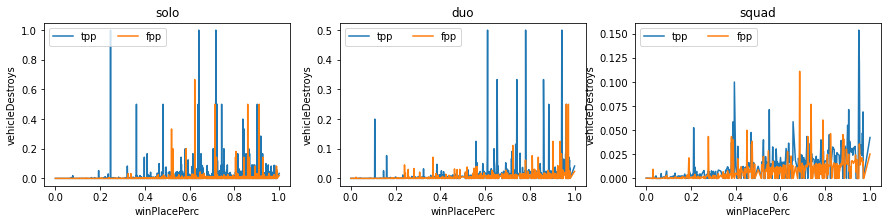

======================================== WALKDISTANCE ============================================================



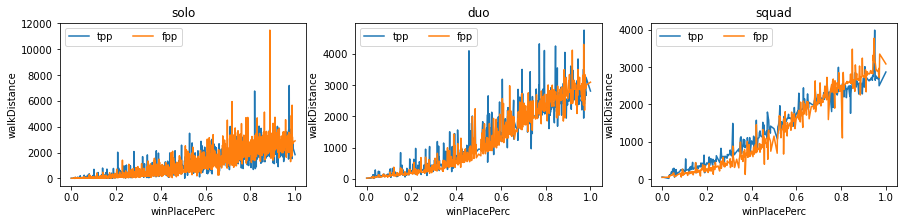

======================================== WEAPONSACQUIRED ============================================================



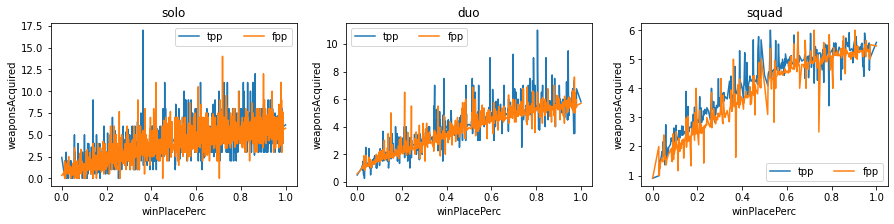

======================================== WINPOINTS ============================================================



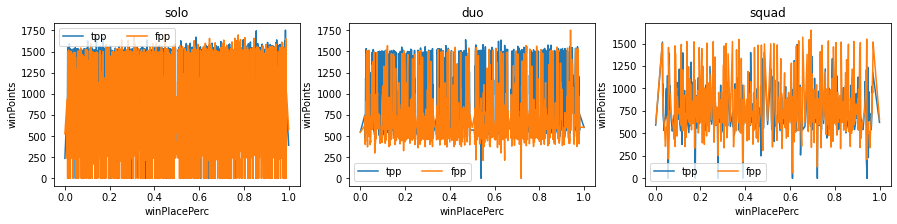

In [140]:
# lineplot
for col in cols:
    print("="*40+" {} ".format(col).upper()+"="*60+"\n")
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    plt.plot(solo_1[col], label='tpp')
    plt.plot(solo_2[col], label='fpp')
    plt.xlabel('winPlacePerc')
    plt.ylabel(col)
    plt.title('solo')
    plt.legend(loc='best', ncol=2)
    
    plt.subplot(1,3,2)
    plt.plot(duo_1[col], label='tpp')
    plt.plot(duo_2[col], label='fpp')
    plt.xlabel('winPlacePerc')
    plt.ylabel(col)
    plt.title('duo')
    plt.legend(loc='best', ncol=2)

    plt.subplot(1,3,3)
    plt.plot(squad_1[col], label='tpp')
    plt.plot(squad_2[col], label='fpp')
    plt.xlabel('winPlacePerc')
    plt.ylabel(col)
    plt.title('squad')
    plt.legend(loc='best', ncol=2)
    plt.show()

======================================== ASSISTS ============================================================



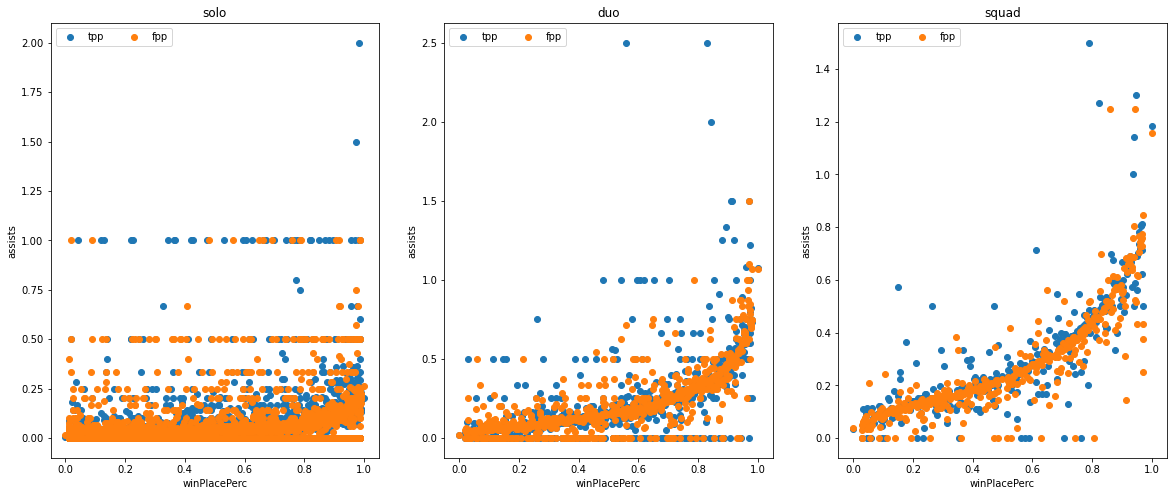

======================================== BOOSTS ============================================================



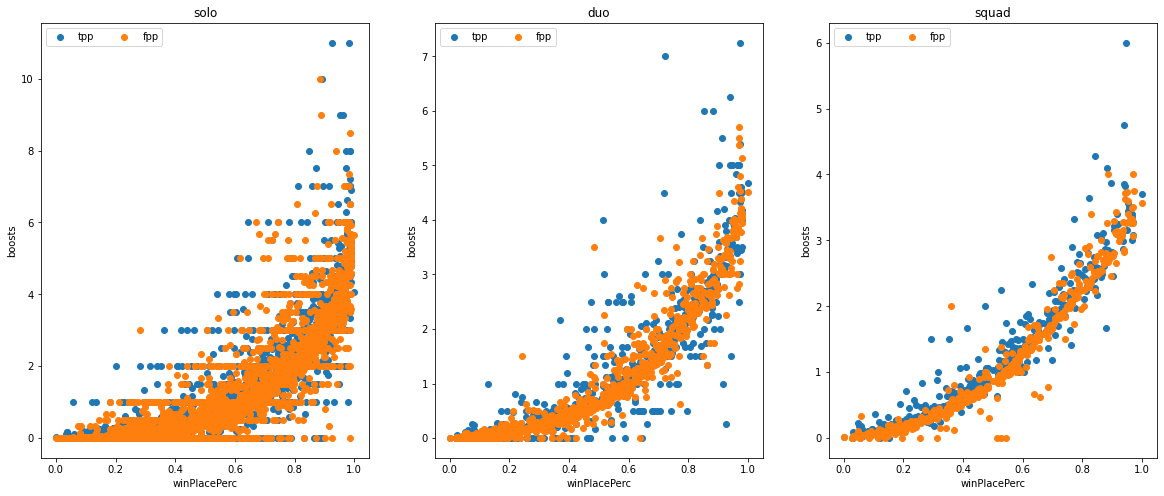

======================================== DAMAGEDEALT ============================================================



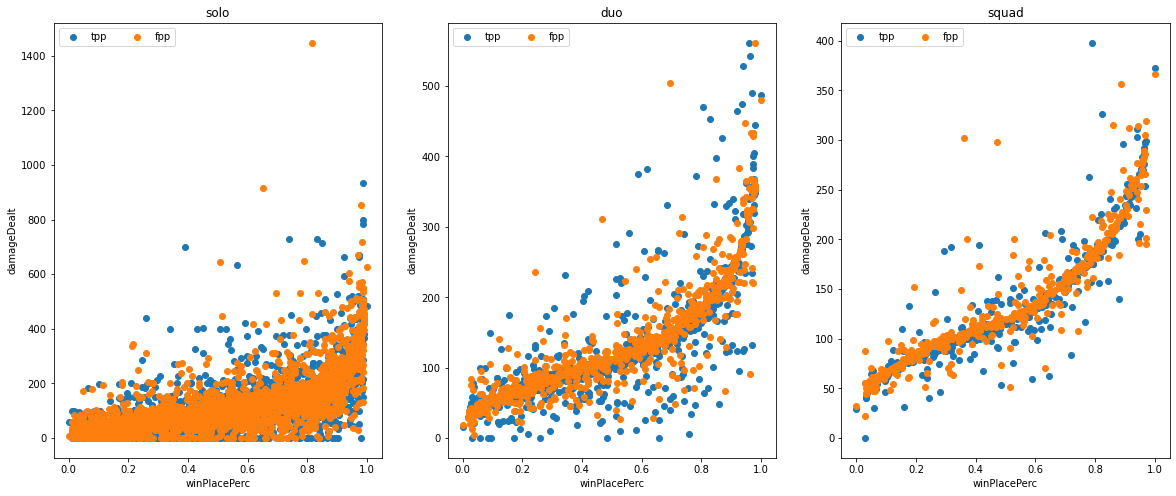

======================================== DBNOS ============================================================



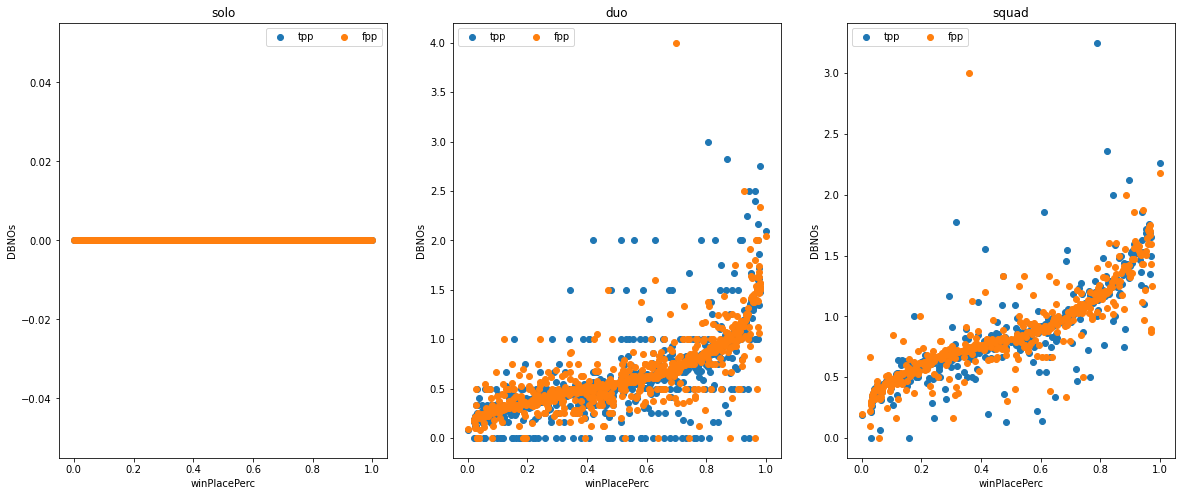

======================================== HEADSHOTKILLS ============================================================



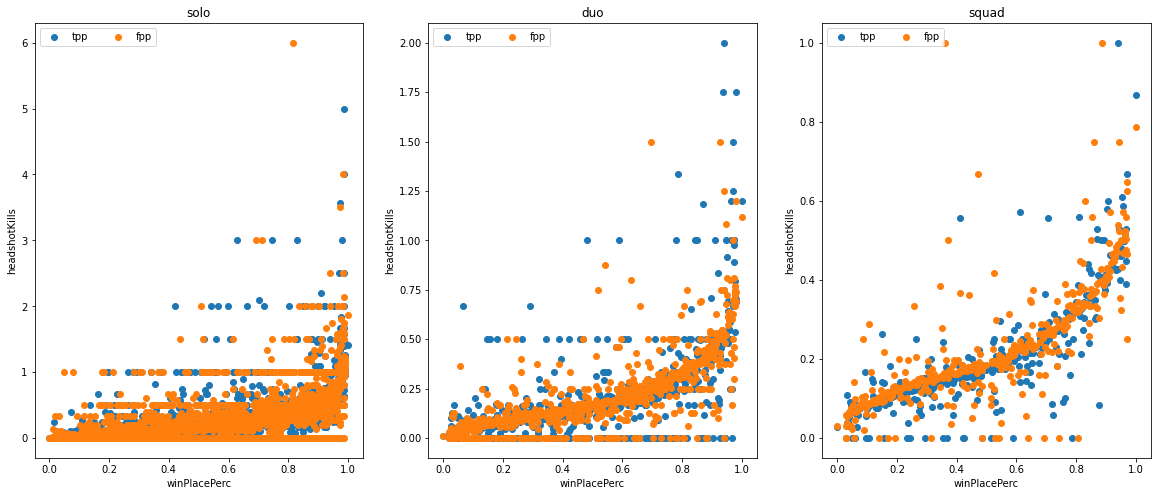

======================================== HEALS ============================================================



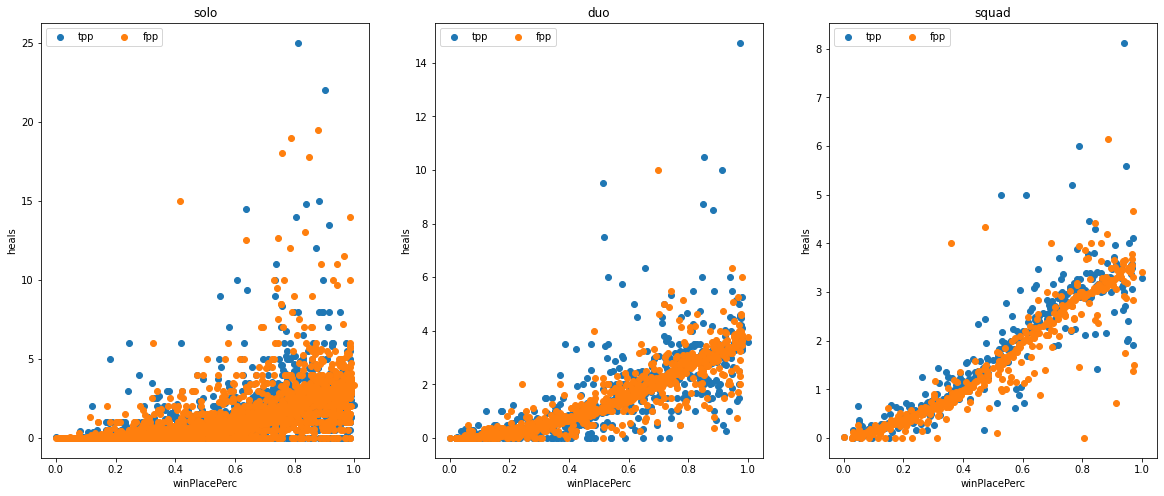

======================================== KILLPOINTS ============================================================



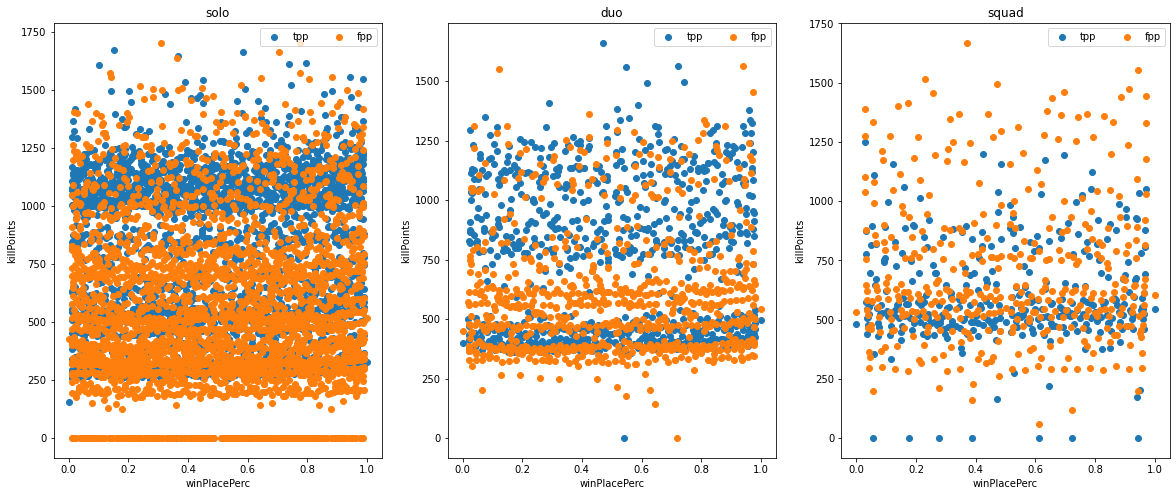

======================================== KILLS ============================================================



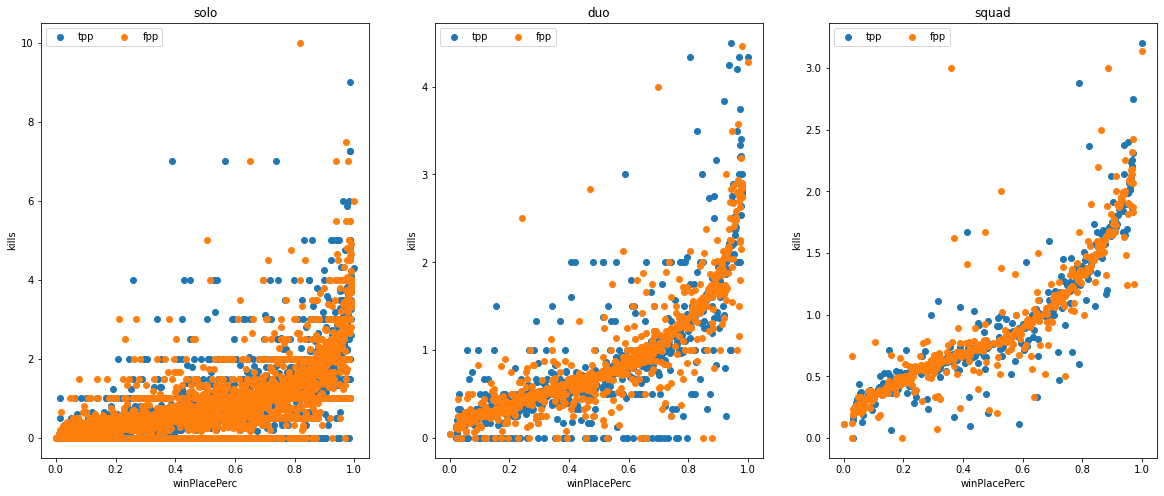

======================================== KILLSTREAKS ============================================================



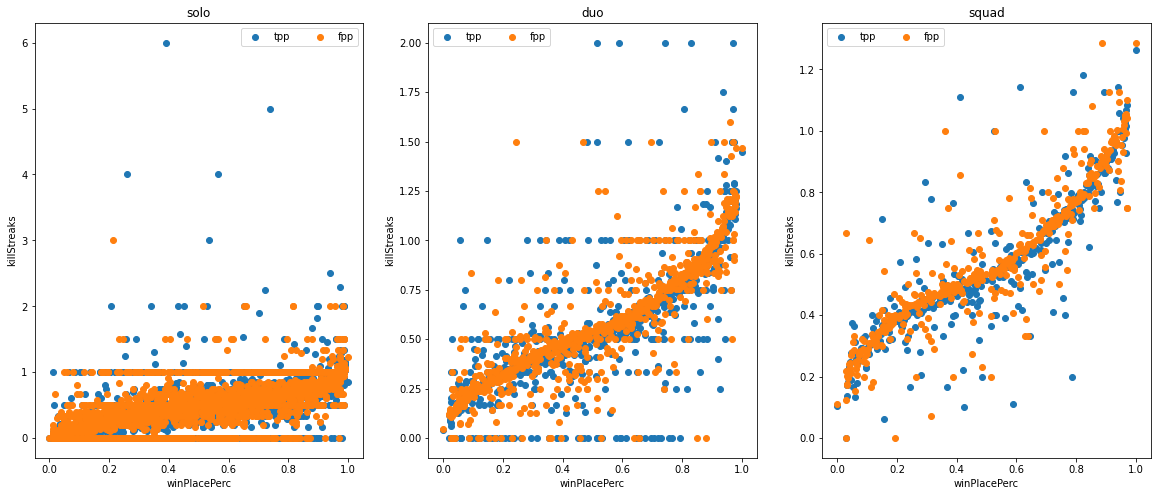

======================================== LONGESTKILL ============================================================



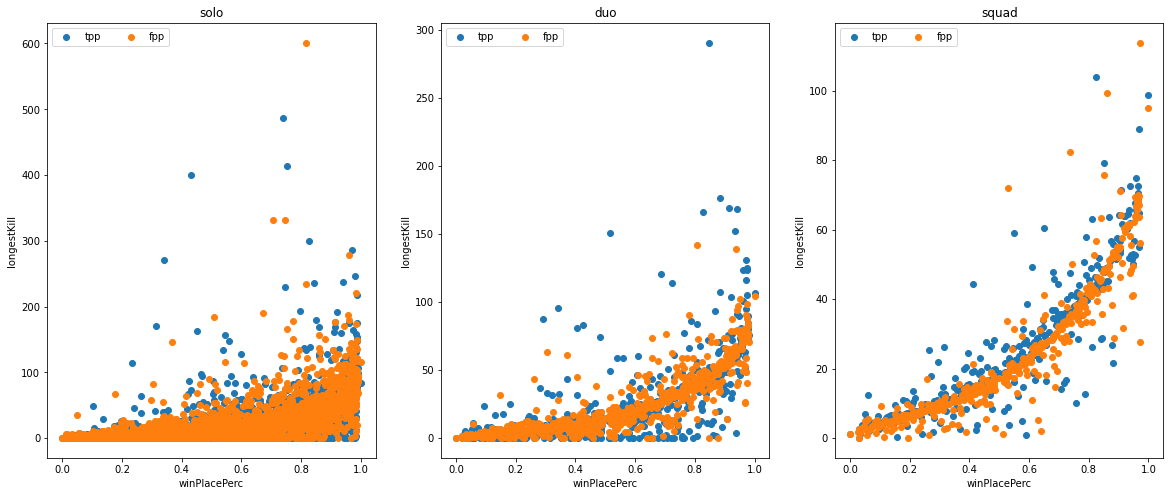

======================================== MATCHDURATION ============================================================



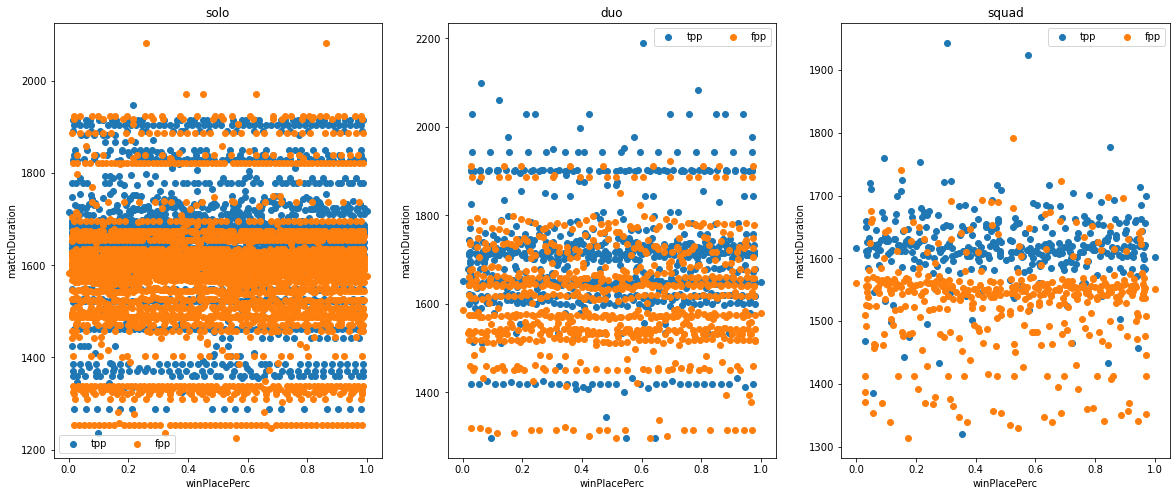

======================================== MAXPLACE ============================================================



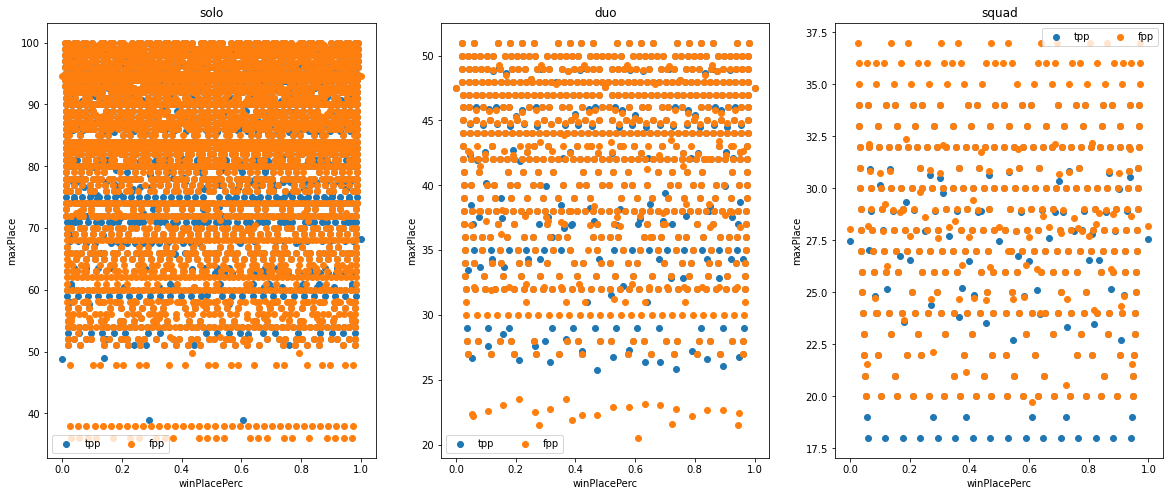

======================================== NUMGROUPS ============================================================



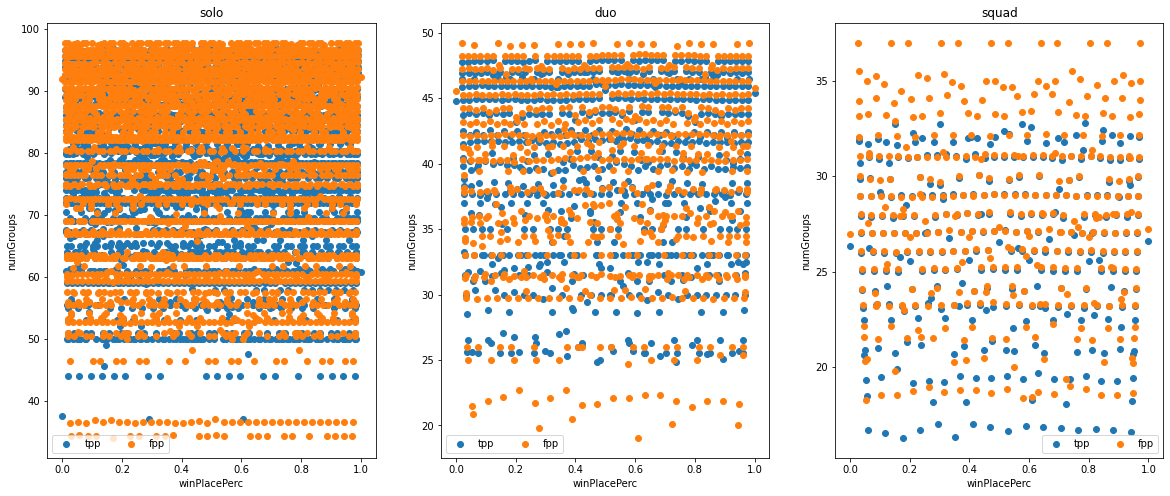

======================================== RANKPOINTS ============================================================



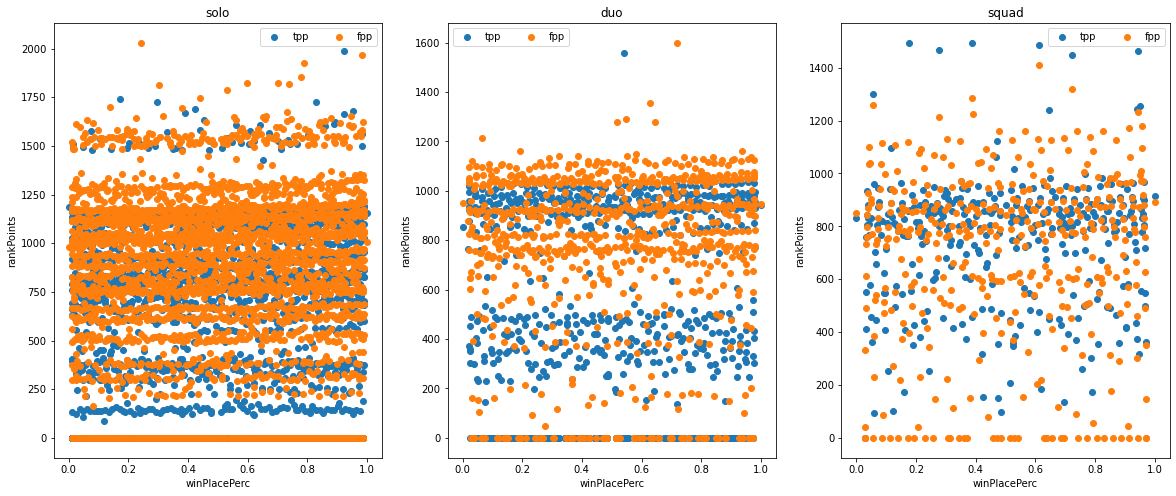

======================================== REVIVES ============================================================



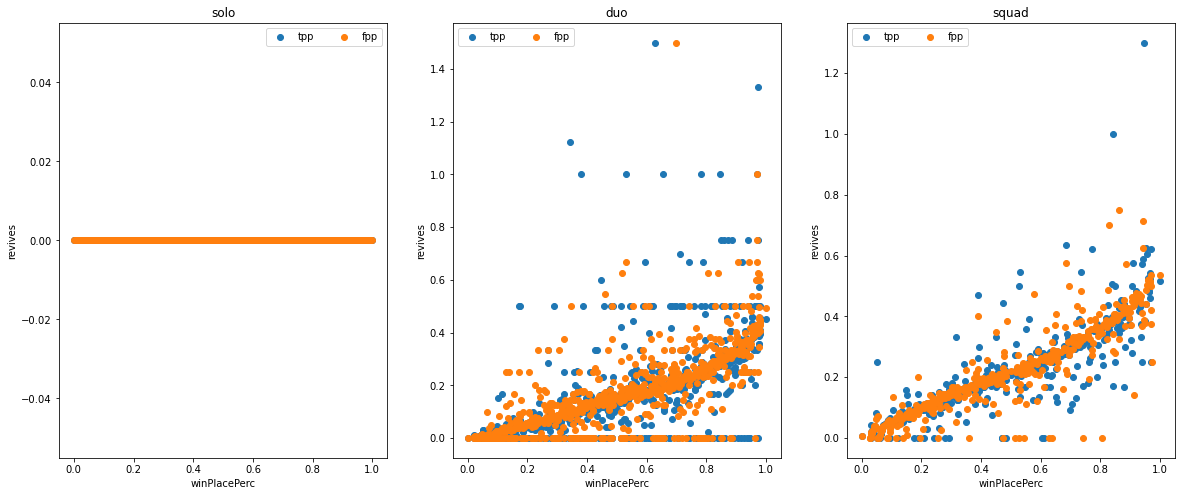

======================================== RIDEDISTANCE ============================================================



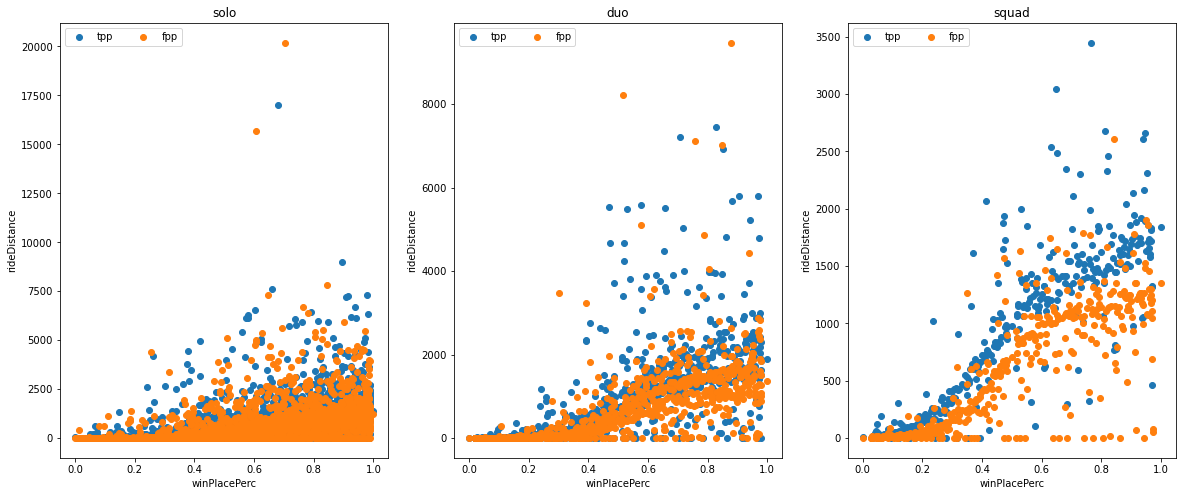

======================================== ROADKILLS ============================================================



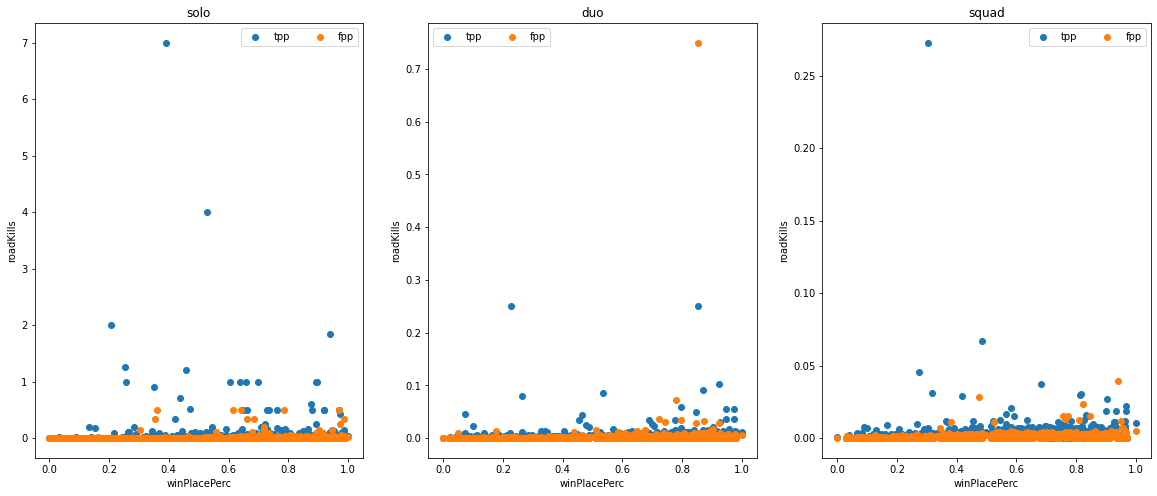

======================================== SWIMDISTANCE ============================================================



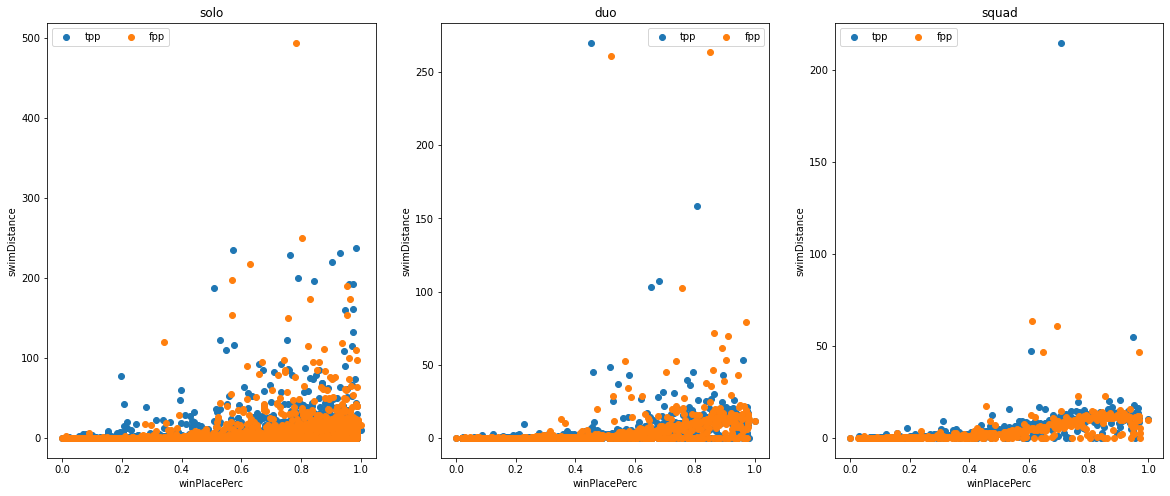

======================================== TEAMKILLS ============================================================



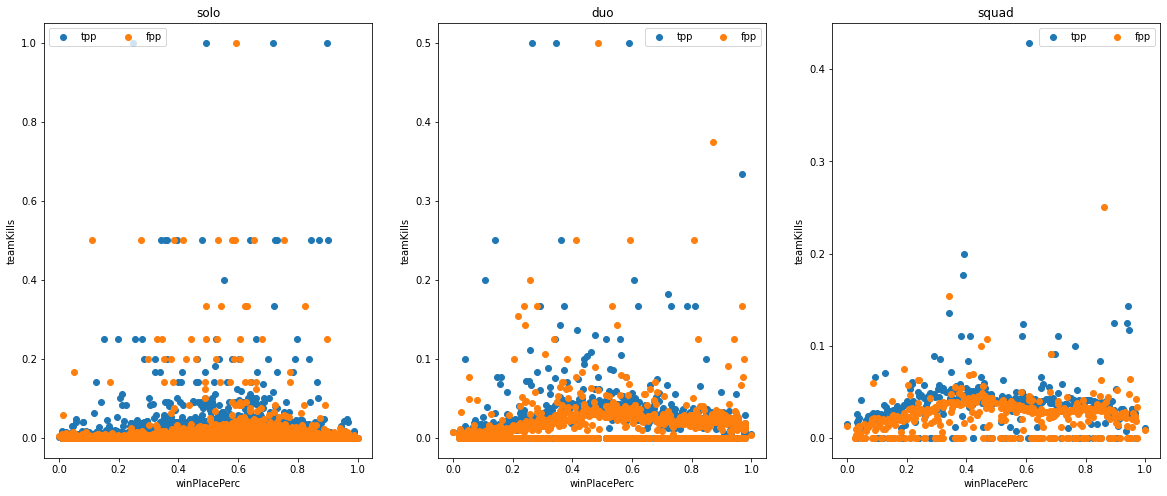

======================================== VEHICLEDESTROYS ============================================================



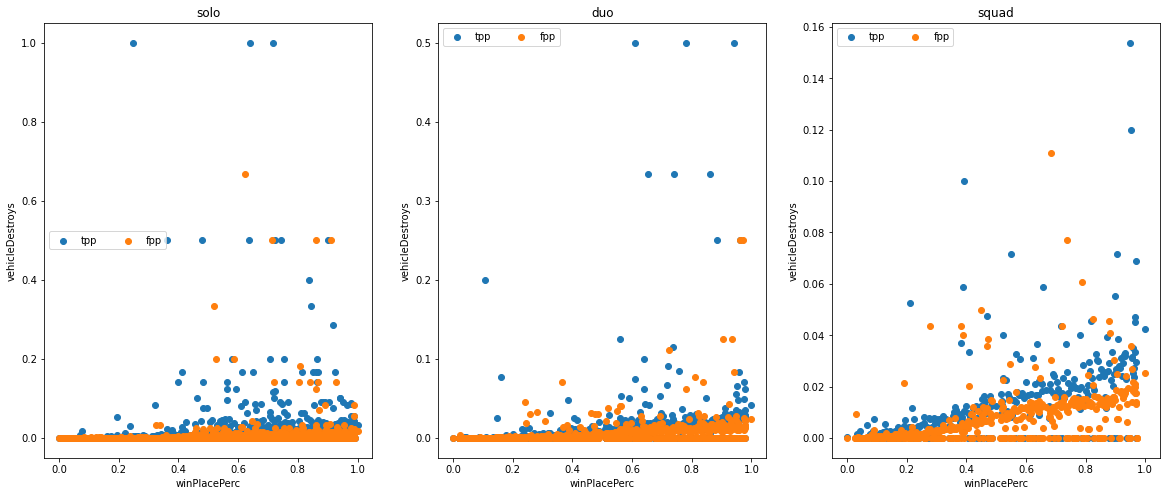

======================================== WALKDISTANCE ============================================================



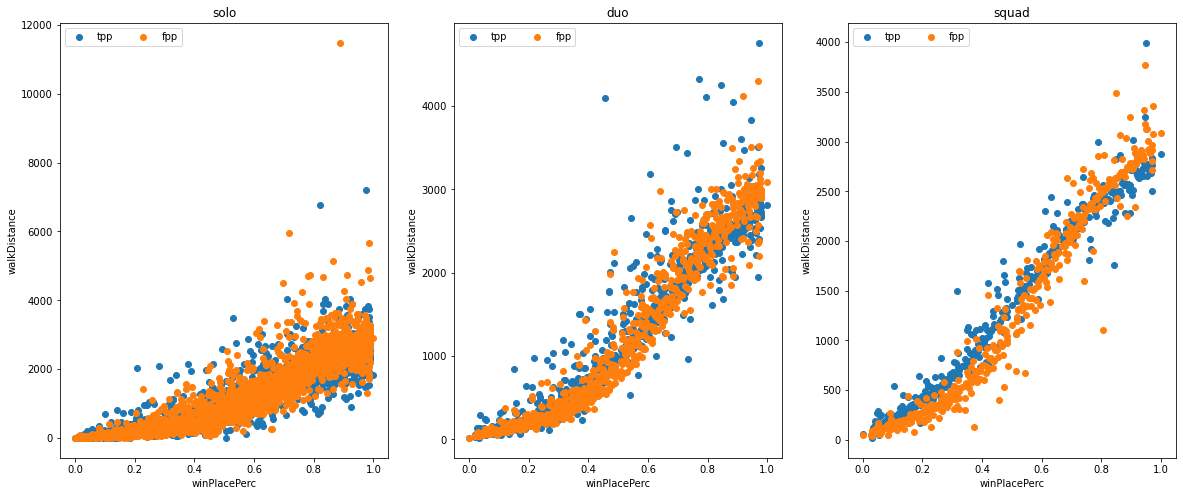

======================================== WEAPONSACQUIRED ============================================================



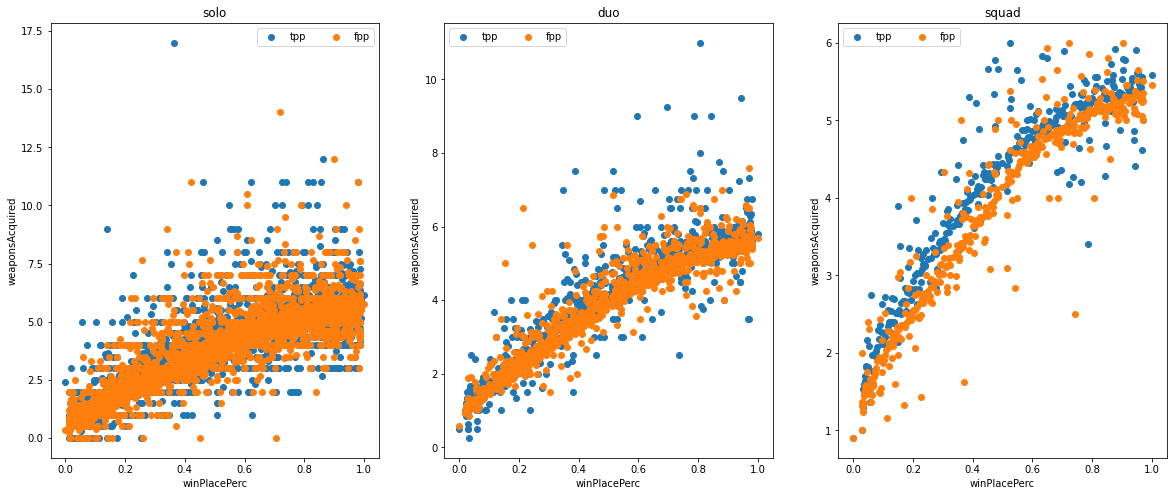

======================================== WINPOINTS ============================================================



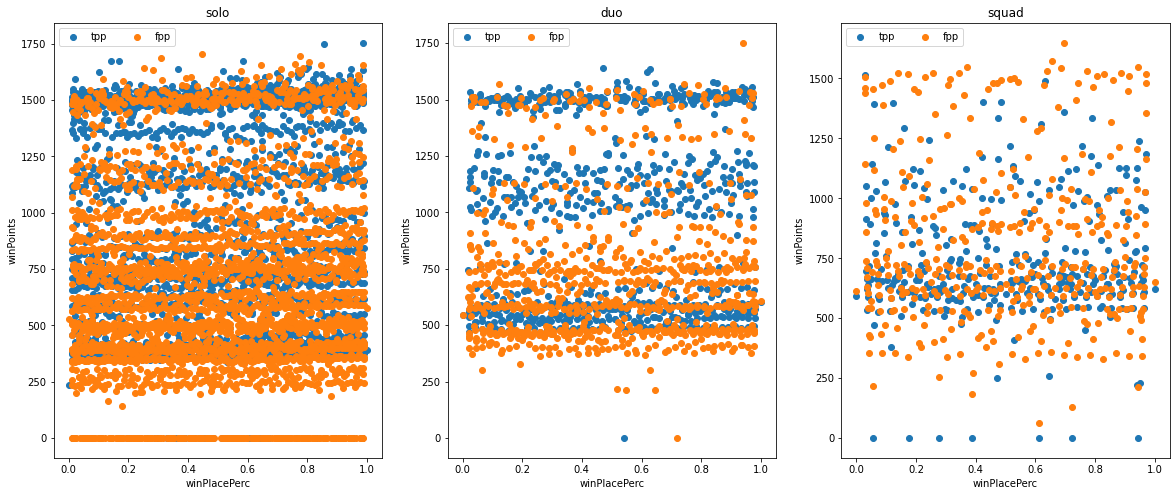

In [156]:
# scatterplot
for col in cols:
    print("="*40+" {} ".format(col).upper()+"="*60+"\n")
    plt.figure(figsize=(20,8))
    plt.subplot(1,3,1)
    plt.scatter(solo_1[col].index, solo_1[col], label='tpp')
    plt.scatter(solo_2[col].index, solo_2[col], label='fpp')
    plt.xlabel('winPlacePerc')
    plt.ylabel(col)
    plt.title('solo')
    plt.legend(loc='best', ncol=2)
    
    plt.subplot(1,3,2)
    plt.scatter(duo_1[col].index, duo_1[col], label='tpp')
    plt.scatter(duo_2[col].index, duo_2[col], label='fpp')
    plt.xlabel('winPlacePerc')
    plt.ylabel(col)
    plt.title('duo')
    plt.legend(loc='best', ncol=2)

    plt.subplot(1,3,3)
    plt.scatter(squad_1[col].index, squad_1[col], label='tpp')
    plt.scatter(squad_2[col].index, squad_2[col], label='fpp')
    plt.xlabel('winPlacePerc')
    plt.ylabel(col)
    plt.title('squad')
    plt.legend(loc='best', ncol=2)
    plt.show()

In [157]:
# winplaceperc 상관관계가 높은 컬럼
# walkdistance 0.81
# weaponsacquired 0.58
# kills 0.42
# heals 0.43
# boosts 0.63
# dabagedealt 0.44

* <font size=4></font>
* <font size=4></font>
* <font size=4></font>
* <font size=4></font>
* <font size=4></font>